# **Regression Model**

**Predicting the Price Of a Residential Property**
- Predicting the selling price of a residential property depends on a number of factors, including the property age, availability of local amenities, and location.
- In this project, I will be using a real estate sales transactions dataset to predict the price-per-unit of a property based on its features. The price-per-unit in this data is based on a unit measurement of 3.3 square meters.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

In [2]:
real_estate = pd.read_csv('real_estate.csv')
real_estate.head()

,transaction_date,house_age,transit_distance,local_convenience_stores,latitude,longitude,price_per_unit
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


**Column Description**
- transaction_date - the transaction date (for example, 2013.250=2013 March, 2013.500=2013 June, etc.)
- house_age - the house age (in years)
- transit_distance - the distance to the nearest light rail station (in meters)
- local_convenience_stores - the number of convenience stores within walking distance
- latitude - the geographic coordinate, latitude
- longitude - the geographic coordinate, longitude
- price_per_unit house price of unit area (3.3 square meters)

### Data Cleaning

In [3]:
# Checking for null values
real_estate.isna().sum()

transaction_date            0
house_age                   0
transit_distance            0
local_convenience_stores    0
latitude                    0
longitude                   0
price_per_unit              0
dtype: int64

In [4]:
# Checking for duplicate values
real_estate.duplicated().sum()

0

In [5]:
# Renaming columns for accessibility
real_estate.rename(columns= {'transaction_date': 'date', 'local_convenience_stores': 'stores', 'price_per_unit': 'unit_price'}, 
                   inplace= True)

The label, price_per_unit is herein refered to as unit price

In [6]:
real_estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              414 non-null    float64
 1   house_age         414 non-null    float64
 2   transit_distance  414 non-null    float64
 3   stores            414 non-null    int64  
 4   latitude          414 non-null    float64
 5   longitude         414 non-null    float64
 6   unit_price        414 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 22.8 KB


#### **Splitting the Date column into Month and Year Columns**

In [7]:
# Unique values in the date column
real_estate.date.unique()

array([2012.917, 2013.583, 2013.5  , 2012.833, 2012.667, 2013.417,
       2013.083, 2013.333, 2013.25 , 2012.75 , 2013.   , 2013.167])

The transaction date is represented by years and months, the month is in a fraction ie a particular month, for instance Febraury when divided by 12 which is the total number of months in a year is 0.167 and so on.

In [8]:
# Splitting the date column into month and year
real_estate['date'] = real_estate['date'].astype(str)
real_estate[['year', 'month']] = real_estate['date'].str.split(".", expand= True)

real_estate.year = real_estate.year.astype(int) # Converting year to int

# Mapping month names to the months in fractions
new_month = {'083': 'January', '167': 'February', '25': 'March', '333': 'April', '417': 'May', '5': 'June', '583': 'July', 
             '667': 'August', '75': 'September', '833': 'October', '917': 'November', '0': 'December'}
real_estate.month = real_estate.month.map(new_month)


# Reording Columns and dropping date column
cols = ['month', 'year', 'house_age', 'transit_distance', 'stores', 'latitude', 'longitude', 'unit_price']
real_estate = real_estate[cols]

real_estate.head(3)

,month,year,house_age,transit_distance,stores,latitude,longitude,unit_price
0,November,2012,32.0,84.87882,10,24.98298,121.54024,37.9
1,November,2012,19.5,306.59470,9,24.98034,121.53951,42.2
2,July,2013,13.3,561.98450,5,24.98746,121.54391,47.3


## EDA

In [9]:
real_estate.drop('year', axis= 1).describe()

,house_age,transit_distance,stores,latitude,longitude,unit_price
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


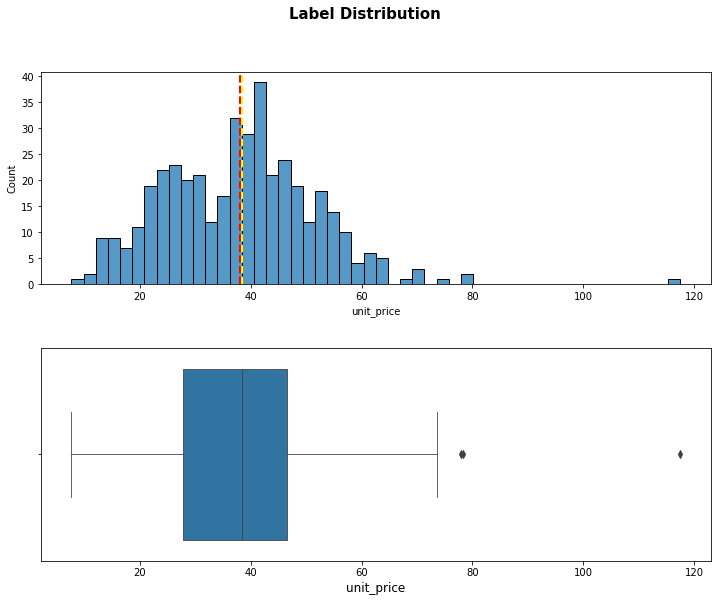

In [10]:
# Visualizing the label
label = real_estate['unit_price']

fig, ax = plt.subplots(2,1, figsize= (12, 9))

sns.histplot(ax= ax[0], x= label, bins= 50)
plt.xlabel('Frequency', size = 12)
ax[0].axvline(label.mean(), color='red', linestyle='dashed', linewidth=2)
ax[0].axvline(label.median(), color='yellow', linestyle='dashed', linewidth=2)


sns.boxplot(ax= ax[1], x= label, linewidth= .8)

plt.suptitle('Label Distribution', fontweight= 'bold', size= 15)
plt.subplots_adjust(hspace= .3)
plt.show()

As seen in the distribution denoted by the histogram and boxplot, There are some outiiers and they'll be removed

In [11]:
# Removing outliers above the 99th percentile
outlier = real_estate.unit_price.quantile(0.99)
real_estate = real_estate[real_estate.unit_price < outlier]

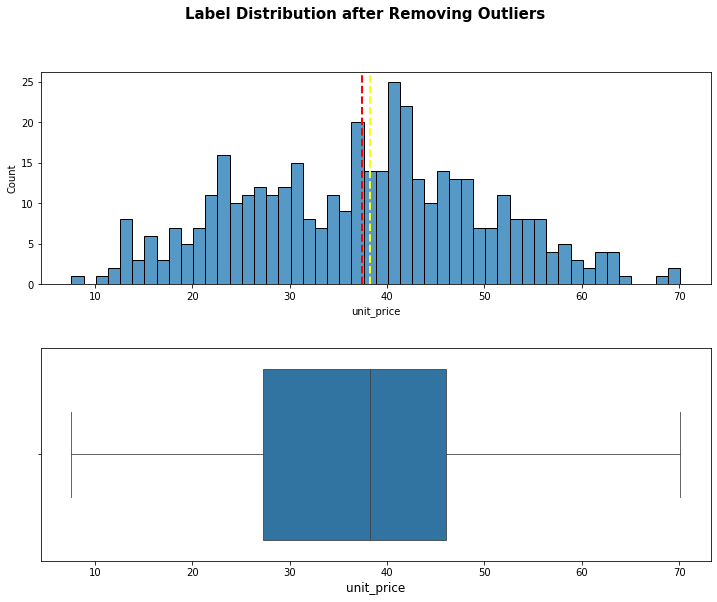

In [12]:
# Visualizing the label after outlier removal
label = real_estate['unit_price']

fig, ax = plt.subplots(2,1, figsize= (12, 9))

sns.histplot(ax= ax[0], x= label, bins= 50)
plt.xlabel('Frequency', size= 12)
ax[0].axvline(label.mean(), color='red', linestyle='dashed', linewidth=2)
ax[0].axvline(label.median(), color='yellow', linestyle='dashed', linewidth=2)

sns.boxplot(ax= ax[1], x= label, linewidth= .8)

plt.suptitle('Label Distribution after Removing Outliers', fontweight= 'bold', size= 15)
plt.subplots_adjust(hspace= .3)
plt.show()

#### Visualizing the Numeric Features by the label, Unit Price

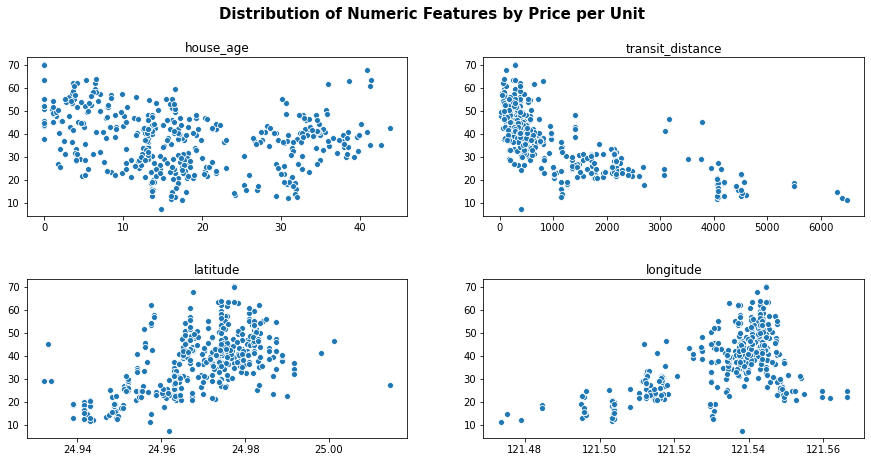

In [13]:
numeric_features  = ['house_age', 'transit_distance', 'latitude', 'longitude']

fig, axes = plt.subplots(2, 2, figsize= (15, 7))
y= 0
for column in numeric_features:
    i, j = divmod(y, 2)
    sns.scatterplot(ax= axes[i, j], y= 'unit_price', x= column, data= real_estate, linewidth= .8)\
    .set(xlabel= None, ylabel= None, title= column)
    y= y + 1


plt.suptitle('Distribution of Numeric Features by Price per Unit', fontweight= 'bold', size = 15)
plt.subplots_adjust(hspace= .4, wspace= .2)
plt.show()

#### Visualizing the categorical features by the label, Unit Price

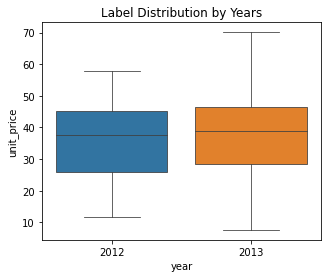

In [14]:
# Visualizing the year distribution by label
plt.figure(figsize= (5, 4))
sns.boxplot(y= 'unit_price', x= 'year', data= real_estate, linewidth= .8)
plt.title('Label Distribution by Years')
plt.show()

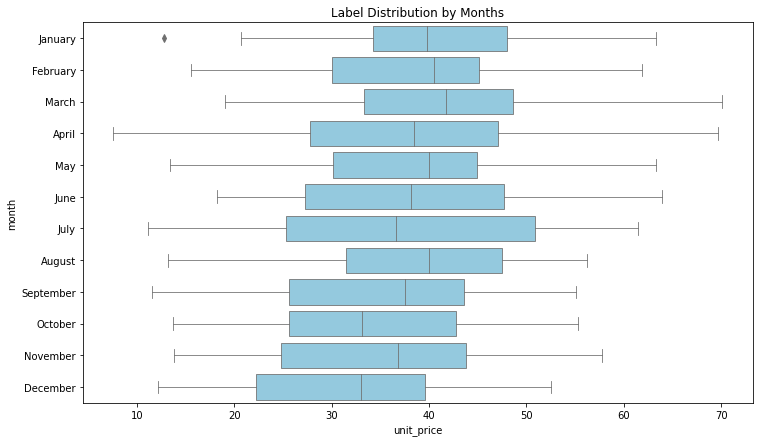

In [15]:
# Visualizing the months distribution by label
plt.figure(figsize= (12, 7))

real_estate['month'] = pd.Categorical(real_estate['month'], ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
                                                            'August', 'September', 'October', 'November', 'December'])


sns.boxplot(x= 'unit_price', y= 'month', data= real_estate, linewidth= .8, color= 'skyblue')
plt.title('Label Distribution by Months')
plt.show()

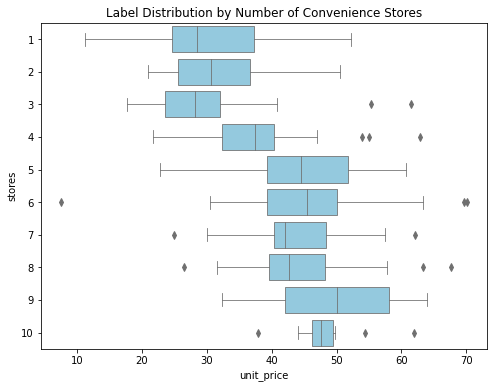

In [16]:
# Visualizing the convenience stores distribution by label
plt.figure(figsize= (8, 6))
real_estate['stores'] = pd.Categorical(real_estate['stores'], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

sns.boxplot(x= 'unit_price', y= 'stores', data= real_estate, linewidth= .8, color= 'skyblue')
plt.title('Label Distribution by Number of Convenience Stores')
plt.show()

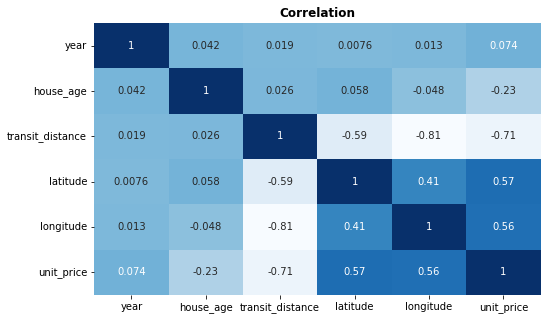

In [17]:
# Visualizing the correlation between columns
plt.figure(figsize= (8, 5))
sns.heatmap(real_estate.corr(), annot= True, cmap= 'Blues', cbar= False)
plt.title('Correlation', fontweight= 'bold', size= 12)
plt.show()

The Correlation of the features by the unit price can be observed in the last line of the heatmap.

## **Modelling**

- From the EDA conducted, there seems to be no dependency variation of the label by the year, so it has a low predictive power and will be dropped accordingly.
- **Features:** Month, House age, Transit_distance, lattitude, longitude
- **Label:** Price per Unit

In [18]:
# Ordinal Encoding of the month column using the map method
month_new = {'January': 0, 'February': 1, 'March': 2, 'April': 3, 'May': 4, 'June': 5, 'July': 6, 'August': 7, 'September': 8, 
             'October':9, 'November': 10, 'December': 11}
real_estate.month= real_estate.month.map(month_new)

In [19]:
# Subsetting for the features
x = real_estate.drop(['unit_price', 'year'], axis = 1)
x.head()

,month,house_age,transit_distance,stores,latitude,longitude
0,10,32.0,84.87882,10,24.98298,121.54024
1,10,19.5,306.59470,9,24.98034,121.53951
2,6,13.3,561.98450,5,24.98746,121.54391
3,5,13.3,561.98450,5,24.98746,121.54391
4,9,5.0,390.56840,5,24.97937,121.54245


In [20]:
# Subsetting for the label
y= real_estate['unit_price']
y.head()

0    37.9
1    42.2
2    47.3
3    54.8
4    43.1
Name: unit_price, dtype: float64

In [21]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state= 0)
print('Training Rows:', len(X_train))
print('Test Rows:', len(X_test))

Training Rows: 286
Test Rows: 123


In [22]:
# Creating a pipeline to carry out scaling on some features

numeric_features = ['house_age', 'transit_distance', 'latitude', 'longitude'] # columns to be scaled 
numeric_transformer  = Pipeline(steps= [('scaler', StandardScaler())])

preprocessor= ColumnTransformer(transformers= [('numeric', numeric_transformer, numeric_features)])

pipeline= Pipeline(steps= [('preprocessor', preprocessor), 
                           ('regressor', RandomForestRegressor())])

model = pipeline.fit(X_train, y_train)

print(model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['house_age',
                                                   'transit_distance',
                                                   'latitude',
                                                   'longitude'])])),
                ('regressor', RandomForestRegressor())])


In [23]:
# Predicting the Unit Price of the test size 
y_pred = model.predict(X_test)
y_pred

array([30.79341667, 35.666     , 49.18000952, 51.13566667, 49.185     ,
       35.04874286, 25.141     , 23.011     , 26.02783333, 40.9111    ,
       49.185     , 48.78802738, 23.683     , 37.60766667, 39.66083333,
       45.36266667, 54.481     , 18.0652    , 50.389     , 24.2415    ,
       38.393     , 36.721     , 53.5465    , 43.535     , 45.13176667,
       47.05103333, 55.401     , 43.326     , 41.0555    , 48.0745    ,
       44.401     , 16.894     , 33.40927619, 38.734     , 28.438     ,
       29.75241667, 64.15      , 51.7415    , 41.111     , 53.365     ,
       34.358     , 38.1005    , 16.45306667, 25.52725   , 40.126     ,
       43.6725    , 36.66536667, 64.15      , 48.80067619, 37.686     ,
       48.094     , 42.96985714, 16.272     , 24.868     , 27.878     ,
       19.187     , 44.309     , 33.05      , 33.481     , 39.616     ,
       49.185     , 21.962     , 36.501     , 57.4699    , 36.724     ,
       44.64575   , 51.365     , 40.17126667, 51.618     , 36.37

In [24]:
model.score(X_train, y_train)

0.9566010209636753

### **Evaluating the Model**

In [25]:
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)
rmse= np.sqrt(mse)
print('Root Mean Squared Error:', rmse)
r2 = r2_score(y_test, y_pred)
print('R2 Score:', r2)

Mean Squared Error: 26.451826752204052
Root Mean Squared Error: 5.143133942666092
R2 Score: 0.8020824573158974


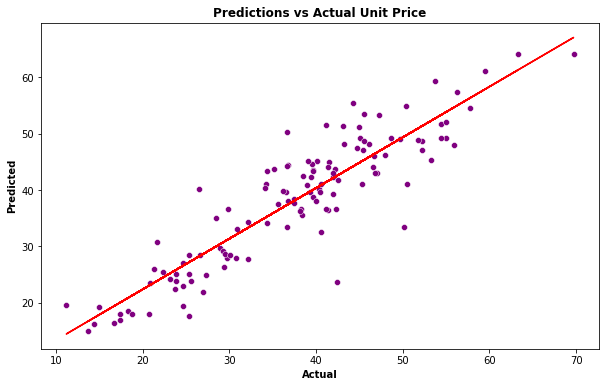

In [26]:
# Plotting Predicted vs Actual Unit Price
plt.figure(figsize= (10, 6))
sns.scatterplot(y_test, y_pred, color= 'purple')
plt.xlabel('Actual', fontweight= 'bold')
plt.ylabel('Predicted', fontweight= 'bold')
plt.title('Predictions vs Actual Unit Price', fontweight= 'bold')
z= np.polyfit(y_test, y_pred, 1)
p= np.poly1d(z)
plt.plot(y_test, p(y_test), color = "red")
plt.show()

### **Testing New Data**

In [27]:
# Saving the model for later use
import joblib
path= './model.pkl'
joblib.dump(model, path)

model= joblib.load(path) 

In [28]:
# Creating a new data to test model on
X_new = pd.DataFrame([[0, 16.2, 289.3248, 5, 24.98203, 121.54348], [11, 13.6, 4082.015, 0, 24.94155, 121.50381]], 
                    columns = ['month', 'house_age', 'transit_distance', 'stores', 'latitude', 'longitude'])

X_new

,month,house_age,transit_distance,stores,latitude,longitude
0,0,16.2,289.3248,5,24.98203,121.54348
1,11,13.6,4082.0150,0,24.94155,121.50381


In [29]:
predicted = model.predict(X_new)
print('Results:')
for i in predicted:
    print(round(i, 2))

Results:
49.18
15.98
